## Семинар 10: "Генерация текстов"

ФИО: Вербин Олег

In [0]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [0]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

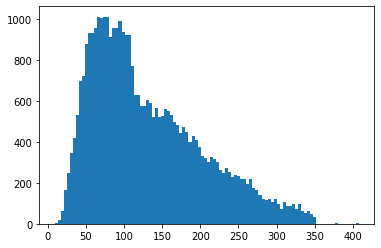

In [6]:
plt.hist(list(map(len, lines)), bins=100);

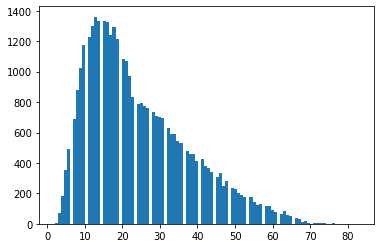

In [7]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [0]:
line = lines[0]

In [9]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [0]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [9]:
np.random.seed(777)
torch.random.manual_seed(777)

In [0]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [0]:
vocab = Vocabulary(lines)

In [0]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [0]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [0]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = torch.LongTensor([len(x[0]) for x in batch]).cuda()
    go = torch.zeros(len(batch), lengths[order[0]]).long().cuda()
    eos = torch.zeros(len(batch), lengths[order[0]]).long().cuda()
    mask = torch.zeros(len(batch), lengths[order[0]]).long().cuda()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [17]:
len(lines)

34251

In [0]:
dataset = Quotes(lines[:-1000], vocab)
testset = Quotes(lines[-1000:], vocab)

In [0]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
testloader = DataLoader(testset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [0]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()
        c = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long().cuda()
            token_id = Variable(token)
            embedding = self.embedding(token_id)
            output, (h,c) = self.generator(embedding, (h,c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax(dim=1)(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.cpu().numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [0]:
oracle = Oracle(vocab.size, embedding_size=128, hidden_size=512, layers=2)
oracle=oracle.cuda()

### Часть 3: обучение модели

In [0]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def gen_test():
    while True:
        for x in testloader:
            yield x

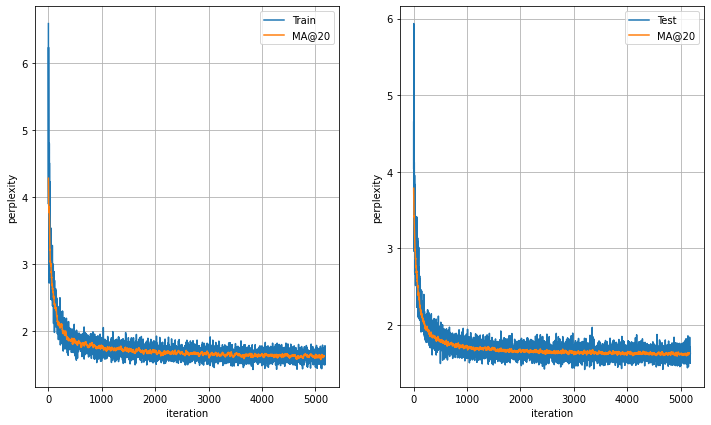

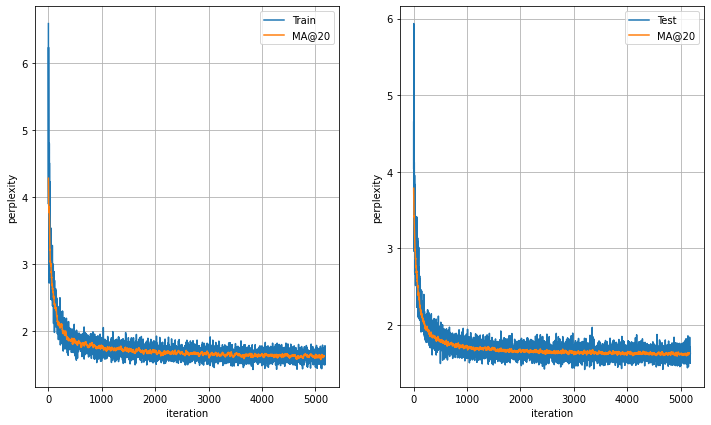

100%|██████████| 520/520 [03:20<00:00,  2.60it/s]



In [31]:
losses = []
test_losses=[]

test=gen_test()

criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        with torch.no_grad():
            (go, eos, mask, length) = next(test)
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).mean()
            test_losses.append(np.exp(loss.item()))

        if i % 50 == 0:
            clear_output(True)
            plt.figure(figsize=(12,7))
            plt.subplot(1,2,1)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            

            plt.subplot(1,2,2)
            plt.plot(test_losses, label='Test')
            plt.plot(moving_average(test_losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [0]:
oracle=oracle.eval()

In [58]:
generate(oracle,vocab)

'A desire despises to be best. You have to use sitcom on a blow opportune.<eos>'

In [52]:
oracle.generate(vocab)

'I control the name at evil in reward to be on patient.<eos>'

In [53]:
oracle.generate(vocab)

"It's not to say that 'Nomah' qualifly better to be scopened now. That stone becomes that you have to"

In [54]:
oracle.generate(vocab)

'There are many worst. I think of courage to put once a little bit of ain air and score, or ever woul'

In [56]:
oracle.generate(vocab)

'Sudan opinion continue to gruest.<eos>'

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисовать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

***Гиперпараметрами здесь могут являться параметры оптимизатора, а так-же архитектура сети. Я буду оптимизирвоать архитектуру сети и буду смотреть только на несколько первых эпох***

In [0]:
def combine(l):
    if len(l)==1:
        yield from [ (i,) for i in l[0]]
    else:
        yield from [(i,*j) for i in l[0] for j in combine(l[1:])]

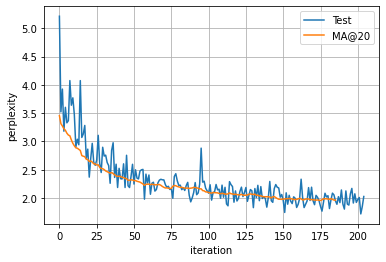

100%|██████████| 520/520 [01:11<00:00,  7.25it/s]


In [19]:
all_losses=[]
for num,(es,hs,l) in enumerate(combine([ [32,64], # embedding_size
                                        [64,128], # hidden_size
                                        [2,3]      # layers
                                    ])):
    
    oracle = Oracle(vocab.size, embedding_size=es, hidden_size=hs, layers=l).cuda()

    test_losses=[]
    test=gen_test()

    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(2):
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
            optimizer.step()

            if i%5==0:
                with torch.no_grad():
                    (go, eos, mask, length) = next(test)
                    prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
                    loss = (criterion(prediction, eos)*mask.float()).mean()
                    test_losses.append(np.exp(loss.item()))

            if i % 50 == 0:
                clear_output(True)
                plt.plot(test_losses, label='Test')
                plt.plot(moving_average(test_losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
    all_losses.append((es,hs,l,test_losses))

In [32]:
for es,hs,l,loss in all_losses:
    print(f'emb_size={es}  hidden_size={hs}  num_layers={l}  min_loss = {min(loss)}')

emb_size=32  hidden_size=64  num_layers=2  min_loss = 1.8558119567629416
emb_size=32  hidden_size=64  num_layers=3  min_loss = 1.9809684129410419
emb_size=32  hidden_size=128  num_layers=2  min_loss = 1.6755602945055397
emb_size=32  hidden_size=128  num_layers=3  min_loss = 1.7597762659731346
emb_size=64  hidden_size=64  num_layers=2  min_loss = 1.7975171473739113
emb_size=64  hidden_size=64  num_layers=3  min_loss = 1.8956758457980591
emb_size=64  hidden_size=128  num_layers=2  min_loss = 1.6358763403003265
emb_size=64  hidden_size=128  num_layers=3  min_loss = 1.7177088964185883


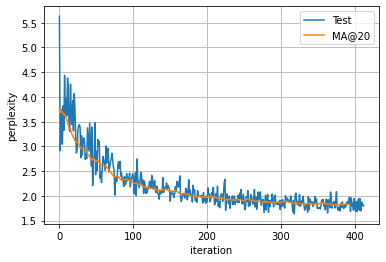

100%|██████████| 520/520 [02:16<00:00,  3.81it/s]


In [21]:
all_losses1=[]
for num,(es,hs,l) in enumerate(combine([ [128], # embedding_size
                                        [256], # hidden_size
                                        [2,4,6]      # layers
                                    ])):
    
    oracle = Oracle(vocab.size, embedding_size=es, hidden_size=hs, layers=l).cuda()

    test_losses=[]
    test=gen_test()

    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(4):
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
            optimizer.step()

            if i%5==0:
                with torch.no_grad():
                    (go, eos, mask, length) = next(test)
                    prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
                    loss = (criterion(prediction, eos)*mask.float()).mean()
                    test_losses.append(np.exp(loss.item()))

            if i % 50 == 0:
                clear_output(True)
                plt.plot(test_losses, label='Test')
                plt.plot(moving_average(test_losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
    all_losses1.append((es,hs,l,test_losses))

In [22]:
for es,hs,l,loss in all_losses1:
    print(f'emb_size={es}  hidden_size={hs}  num_layers={l}  min_loss = {min(loss)}')

emb_size=128  hidden_size=256  num_layers=2  min_loss = 1.4992072860413481
emb_size=128  hidden_size=256  num_layers=4  min_loss = 1.5107734024007053
emb_size=128  hidden_size=256  num_layers=6  min_loss = 1.6356494599727134


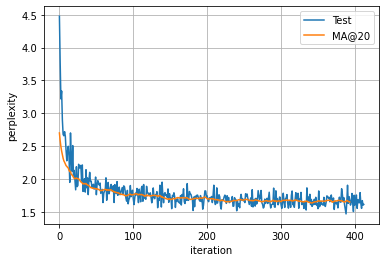

100%|██████████| 520/520 [04:51<00:00,  1.78it/s]


In [28]:
all_losses2=[]
for num,(es,hs,l) in enumerate(combine([ [128,256,512], # embedding_size
                                        [256,512,768], # hidden_size
                                        [2]      # layers
                                    ])):
    
    oracle = Oracle(vocab.size, embedding_size=es, hidden_size=hs, layers=l).cuda()

    test_losses=[]
    test=gen_test()

    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(4):
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
            optimizer.step()

            if i%5==0:
                with torch.no_grad():
                    (go, eos, mask, length) = next(test)
                    prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
                    loss = (criterion(prediction, eos)*mask.float()).mean()
                    test_losses.append(np.exp(loss.item()))

            if i % 50 == 0:
                clear_output(True)
                plt.plot(test_losses, label='Test')
                plt.plot(moving_average(test_losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
    all_losses2.append((es,hs,l,test_losses))

In [29]:
for es,hs,l,loss in all_losses2:
    print(f'emb_size={es}  hidden_size={hs}  num_layers={l}  min_loss = {min(loss)}')

emb_size=128  hidden_size=256  num_layers=2  min_loss = 1.5382713625797597
emb_size=128  hidden_size=512  num_layers=2  min_loss = 1.4540874218445663
emb_size=128  hidden_size=768  num_layers=2  min_loss = 1.481269180718964
emb_size=256  hidden_size=256  num_layers=2  min_loss = 1.5195762159059376
emb_size=256  hidden_size=512  num_layers=2  min_loss = 1.4833797227396932
emb_size=256  hidden_size=768  num_layers=2  min_loss = 1.477756035535145
emb_size=512  hidden_size=256  num_layers=2  min_loss = 1.5491265737602686
emb_size=512  hidden_size=512  num_layers=2  min_loss = 1.4956107231226305
emb_size=512  hidden_size=768  num_layers=2  min_loss = 1.467178361116069


***Больший размер embedding_size или hidden_size ожидаемо улучшает качество. Интересно, что количество слоёв в LSTM лишь ухудшает качество. Это может быть связано с двумя вещами:<br>
1) Прошло недостаточно количество эпох. Модель становится более сложной и не успевает обучиться<br>
2) В LSTM есть много запоминающих элементов, возможно из-за этого сеть переобучивается (вряд-ли, потому что прошло слишком мало итераций и модель не особо подвержена переобучению)<br>
3) Мы генерируем лишь одно предложение, видимо в двух слоях достаточно памяти чтобы запомнить важную часть контекста***

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: